### This notebook contains code used to map neuronal clusters in Minerva et al. to cell types in the Allen Brain Atlas 

#### Import packages

In [1]:
suppressPackageStartupMessages(library("anndata"))
suppressPackageStartupMessages(library("data.table"))
suppressPackageStartupMessages(library("ggalluvial"))
suppressPackageStartupMessages(library("Matrix"))
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("tidyverse"))

Warning message:
“package ‘data.table’ was built under R version 4.4.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”


#### Preprocess data to be compatible with MapMyCells

In [ ]:
neurons <- readRDS("./analysis_outputs/seurat_objects/neuron_subset.RDS")
Idents(neurons) <- factor(Idents(neurons), 
                          levels = c("DA","Mixed","Glut","GABA-1","GABA-2",
                                     "GABA-3","GABA-4","GABA-5","GABA-6"))
DefaultAssay(neurons) <- "RNA"

In [6]:
# Extract the counts matrix (cells as rows, genes as columns)
count_mat <- t(as.matrix(GetAssayData(neurons, slot = "counts")))

# Make sure IDs exist
stopifnot(!is.null(rownames(count_mat)), !is.null(colnames(count_mat)))

# Write as gzip CSV (IMPORTANT: close the connection)
con <- gzfile("./mapmycells/neurons_counts.csv.gz", "w")
write.csv(count_mat, file = con, quote = FALSE, row.names = TRUE)
close(con)  

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 11.3 GiB”


In [7]:
# Convert the count matrix to sparse dgCMatrix (R’s equivalent of Python CSR)
count_sparse <- as(Matrix(count_mat, sparse = TRUE), "dgCMatrix")

# Add metadata
cell_ids = data.frame(row.names = rownames(count_mat))
gene_names = data.frame(row.names = colnames(count_mat))

# Create AnnData object for use with MapMyCells
ad = AnnData(X=count_mat, obs=cell_ids, var=gene_names)

write_h5ad(ad, "./mapmycells/neurons_for_mapmycells.h5ad", compression = "gzip")

[1] "Converting to sparse dgCMatrix (R’s equivalent of Python CSR)"
[1] "Storing metadata"


In [12]:
file.size("./mapmycells/neurons_for_mapmycells.h5ad") # Must be less than 2,147,483,648 (2GB)

[1] 239820749

#### Go to https://knowledge.brain-map.org/mapmycells/process/ for next steps

#### After running map my cells at the link above, return here

In [6]:
mapping <- read.csv("./mapmycells/droplet_library_mapping.csv", comment.char="#")

In [7]:
# Extract metadata and add cell IDs to map our manual clusters to the mapped classes
meta <- neurons@meta.data
meta$cell_id <- rownames(meta)

# Merge only the needed columns from mapping
merged_meta <- merge(
  meta[, c("cell_id", "sampleID", "sex", "outcome", "cluster.names", "subcluster.names")],
  mapping[, c("cell_id", "class_name", "subclass_name")],  
  by = "cell_id",
  all.x = TRUE)

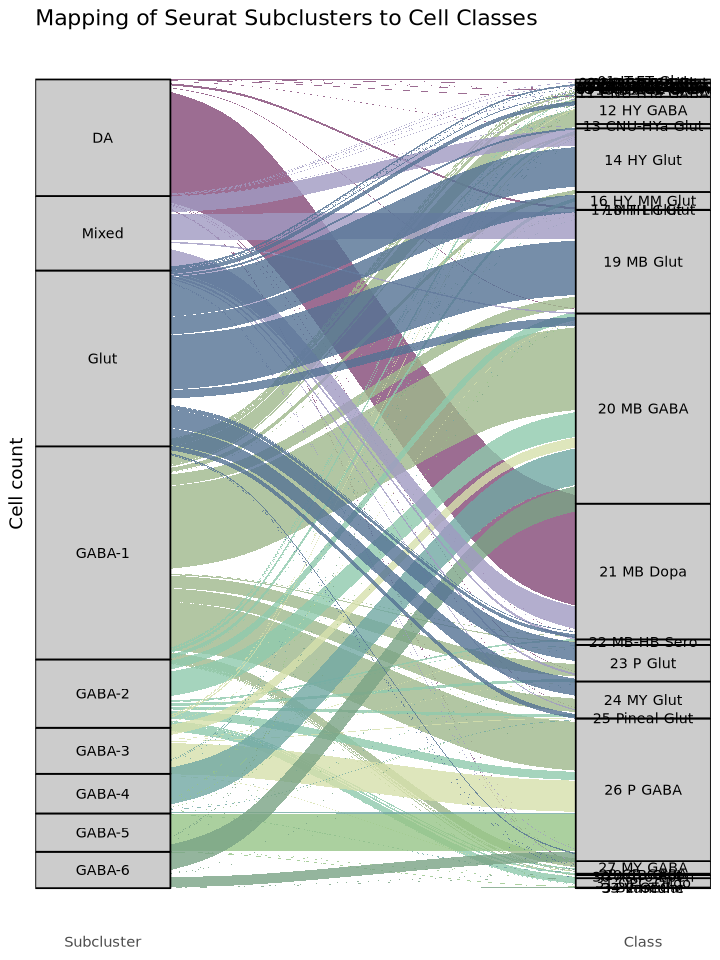

In [8]:
# Prepare data for plotting
df_alluvial <- merged_meta %>%
  count(subcluster.names, class_name)

# Create alluvial plot
neuron_pal <- c('DA'='#834977', 'Mixed'='#A09AC1', 'Glut'='#547294', 'GABA-1'='#9fb88c', 'GABA-2'='#8fc9ad', 
                'GABA-3'='#D6E0AB', 'GABA-4'='#71a8a2', 'GABA-5'='#96c487', 'GABA-6'='#7aa385') 

options(repr.plot.width = 6, repr.plot.height = 8) 
ggplot(df_alluvial, aes(axis1 = factor(subcluster.names, levels = c("DA","Mixed","Glut","GABA-1","GABA-2",
                                                                    "GABA-3","GABA-4","GABA-5","GABA-6")), 
                        axis2 = class_name, y = n)) +
  geom_alluvium(aes(fill = subcluster.names), alpha=0.8, width = 1/12) +
  geom_stratum(width = 1/4, fill = "grey80", color = "black") +
  geom_text(stat = "stratum", aes(label = after_stat(stratum)), size = 3) +
  scale_x_discrete(limits = c("Subcluster", "Class"), expand = c(.05, .05)) +
  scale_fill_manual(values = neuron_pal, name = "Subcluster") +
  labs(x = NULL, y = "Cell count",
       title = "Mapping of Seurat Subclusters to Cell Classes") +
  theme_minimal() +
  theme(legend.position = "none",
        axis.text.y = element_blank(),
        panel.grid = element_blank())

In [10]:
top90_by_cluster <- merged_meta %>%
  filter(!is.na(subcluster.names), !is.na(class_name)) %>%
  count(subcluster.names, class_name, name = "n") %>%
  group_by(subcluster.names) %>%
  mutate(total = sum(n), p = n / total) %>%
  arrange(subcluster.names, desc(p), desc(n), class_name) %>%
  mutate(cum_p = cumsum(p), cum_p_lag = lag(cum_p, default = 0)) %>%
  # keep rows until the cumulative share reaches 90% (inclusive)
  filter(cum_p_lag < 0.90) %>%
  mutate(label = paste0(class_name, " (", sprintf("%.1f%%", 100 * p), ")")) %>%
  summarise(top_90 = paste(label, collapse = ", "), .groups = "drop")

colnames(top90_by_cluster) <- c("ARM clusters", "ABC clusters")
top90_by_cluster
write.csv(top90_by_cluster, "./mapmycells/top90pct_mapping.csv", row.names = FALSE, quote = FALSE)


ARM clusters,ABC clusters
<fct>,<chr>
DA,21 MB Dopa (94.9%)
GABA-1,"20 MB GABA (38.8%), 26 P GABA (22.8%), 12 HY GABA (8.3%), 24 MY Glut (6.2%), 23 P Glut (5.8%), 19 MB Glut (5.3%), 27 MY GABA (4.1%)"
GABA-2,"20 MB GABA (36.2%), 19 MB Glut (12.6%), 26 P GABA (12.1%), 31 OPC-Oligo (10.1%), 14 HY Glut (5.4%), 24 MY Glut (4.2%), 23 P Glut (4.1%), 12 HY GABA (4.0%), 30 Astro-Epen (2.5%)"
GABA-3,"26 P GABA (67.7%), 20 MB GABA (22.2%), 12 HY GABA (2.9%)"
GABA-4,20 MB GABA (92.5%)
GABA-5,26 P GABA (96.3%)
GABA-6,"20 MB GABA (69.5%), 26 P GABA (27.8%)"
Mixed,"19 MB Glut (35.4%), 21 MB Dopa (30.1%), 14 HY Glut (21.3%), 23 P Glut (3.4%)"
Glut,"19 MB Glut (31.0%), 14 HY Glut (22.5%), 23 P Glut (10.5%), 16 HY MM Glut (10.0%), 24 MY Glut (9.7%), 20 MB GABA (4.8%), 26 P GABA (2.7%)"
